In [1]:
%reset -f
import numpy as np
import sys
from os import system
from os import listdir
from natsort import realsorted, natsorted
from math import pi
import matplotlib.pyplot as plt

In [2]:
initFolder  = "last2segsAt0.05"  #Original data
tempFolder1 = "tempFolder1"   #Keep only P
tempFolder2 = "tempFolder2"   #Save heads

### Convert to single files of p_rho

In [3]:
system('''
initFolder={}
tempFolder1={}
rm -rf $tempFolder1; mkdir $tempFolder1
cd $initFolder
for file in $(ls -v)
do
  # Remove header line
  #   ╚ Sort based on X coordinate (Third column)
  #      ╚ Keep only the pressure data (Second column)
  sed "1d" $file | sort -k3 -g -t"," | cut -d "," -f 2 > ../$tempFolder1/$file 
done
cd ..
'''.format(initFolder,tempFolder1))

0

### Assemble all into a big matrix 

Each row is a X-location and each column a time-location

In [4]:
system('''
tempFolder1={}
tempFolder2={}
rm -r $tempFolder2; mkdir $tempFolder2
cd $tempFolder1
listFiles=$(ls -v)
paste -d "," $listFiles > ../$tempFolder2/BIGMAT 
cd ..
'''.format(tempFolder1,tempFolder2))

0

In [5]:
# create a list of times
endTime = 0.05*45
deltaTime = 0.05
realTimes = np.arange(0,endTime,deltaTime)
p_rhoFiles = natsorted(listdir(tempFolder1))

63


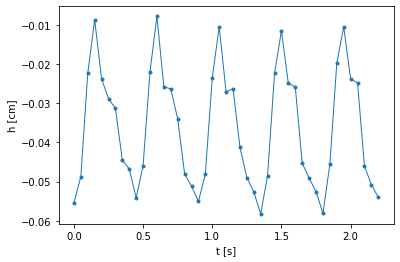

In [6]:
A = np.loadtxt("tempFolder2/BIGMAT",delimiter=",")
pickAFileToChek = int(200*4.7727/15)

for i in [pickAFileToChek]:
    A0 = A[i]
    plt.plot(realTimes,A0*100/9.81,marker='.',lw=1)
    plt.ylabel("h [cm]")
    plt.xlabel("t [s]")
    print(i)
    plt.show()

### Calculate real.FFT fo the sampled point

The frequency $0$ Hz corresponds to the vertical shift of the signal. Since we're using a real.fft, that value is doubled because the negative frequencies are dumped.

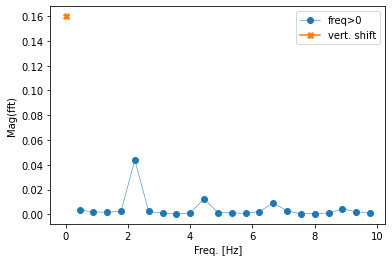

In [7]:
FFTA = np.fft.rfft(A0)
MAGNITUDE = np.abs(FFTA)
FREQ = np.fft.rfftfreq(A0.size,d=0.05)

plt.plot(FREQ[1:],MAGNITUDE[1:],marker='o',lw=0.5,label="freq>0")
plt.plot(FREQ[0],MAGNITUDE[0],marker='X',label="vert. shift")
plt.ylabel("Mag(fft)")
plt.xlabel("Freq. [Hz]")
plt.legend()
plt.show()

In [8]:
allInformation = sorted(list(zip(FREQ,MAGNITUDE,FFTA)),
                        key= lambda x: x[1],
                        reverse = True)

### Reconstruct the signal only from some important frequencies

In [9]:
howManyFreqs = 5
reconstructInfo = allInformation[:howManyFreqs]

In [10]:
reconstructInfo = sorted(reconstructInfo,
                        key= lambda x: x[0],
                        reverse = False)

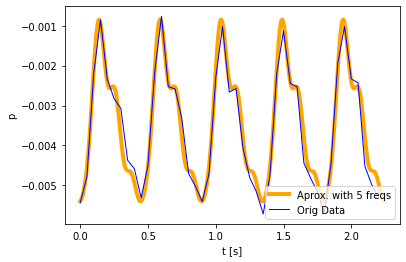

In [11]:
finerTimes = np.arange(0,endTime,deltaTime/10)
FUNC = np.zeros_like(finerTimes)

for i in reconstructInfo:
    myAmpl = i[2]
    myFreq = i[0]
    if myFreq == 0.0:
        FUNC += myAmpl.real/2
    else:
        FUNC += myAmpl.real * np.cos(finerTimes*2*pi*myFreq) -\
            myAmpl.imag * np.sin(finerTimes*2*pi*myFreq)

FUNC = FUNC/(FFTA.size)
plt.plot(finerTimes,FUNC,lw=4,label="Aprox. with "+str(howManyFreqs)+" freqs",c="orange")
plt.plot(realTimes,A0,lw=1,label="Orig Data",c="blue")
plt.legend(loc="lower right")
plt.ylabel("p")
plt.xlabel("t [s]")
plt.show()

# Do the same now for ALL points

This will create a C++ file containing a function storing a list of frequencies and amplitudes to reconstruct all those spectres. 

The file is a series of `if` clauses stored in tempFolder2

In [12]:
system('''
    initFolder={0}
    tempFolder2={1}
    cd $initFolder
    file=$(ls | shuf -n 1)
    sed "1d" $file | sort -k3 -g -t"," | cut -d "," -f 3,4,5 |tee ../$tempFolder2/points
    cd ..
    pwd
'''.format(initFolder,tempFolder2)
      )

0

In [13]:
XCoordsTOWRITE = np.loadtxt(tempFolder2+"/points",delimiter=",",usecols=0)
print(XCoordsTOWRITE)

[0.         0.         0.0015202  0.0015202  0.00303742 0.00303742
 0.00455178 0.00455178 0.00606345 0.00606345 0.00757267 0.00757267
 0.00907973 0.00907973 0.0105849  0.0105849  0.0120886  0.0120886
 0.0135911  0.0135911  0.0150928  0.0150928  0.0165941  0.0165941
 0.0180954  0.0180954  0.019597   0.019597   0.0210994  0.0210994
 0.022603   0.022603   0.024108   0.024108   0.0256149  0.0256149
 0.0271239  0.0271239  0.0286353  0.0286353  0.0301494  0.0301494
 0.0316663  0.0316663  0.0331863  0.0331863  0.0347092  0.0347092
 0.0362352  0.0362352  0.0377641  0.0377641  0.0392958  0.0392958
 0.04083    0.04083    0.0423662  0.0423662  0.043904   0.043904
 0.0454426  0.0454426  0.0469812  0.0469812  0.0485189  0.0485189
 0.0500546  0.0500546  0.0515861  0.0515861  0.0531109  0.0531109
 0.0546275  0.0546275  0.056135   0.056135   0.0576328  0.0576328
 0.0591208  0.0591208  0.0605992  0.0605992  0.0620683  0.0620683
 0.0635287  0.0635287  0.064981   0.064981   0.0664261  0.0664261
 0.067864

In [14]:
howManyFreqs = 5
f = open(tempFolder2+"/conditionalsForHeader_codeStream.cpp", "w+")

count = 0
LISTSECON = [[],[],[],[],[]]
for A0 in A[::2]:
    FFTA = np.fft.rfft(A0)
    MAGNITUDE = np.abs(FFTA)
    FREQ = np.fft.rfftfreq(A0.size,d=0.05)
    N = FFTA.size
    
    allInformation = sorted(list(zip(FREQ,MAGNITUDE,FFTA)),
                        key= lambda x: x[1],
                        reverse = True)
    #reconstructInfo = sorted(allInformation[:howManyFreqs],
    #                    key= lambda x: x[0],
    #                    reverse = False)
    reconstructInfo = allInformation[:howManyFreqs]
    
    if count+2 < len(XCoordsTOWRITE):
        f.write("if (X >= {:} && X <= {:})\n{{".format(XCoordsTOWRITE[count],XCoordsTOWRITE[count+2]))
        
    order = 0
    for i in reconstructInfo:
        myFreq = i[0]
        AmpCOS = i[2].real
        AmpSIN = i[2].imag
        
        if myFreq == 0.0:
            AmpCOS = AmpCOS/(2*N)
            AmpSIN = AmpSIN/(2*N)
        else:
            AmpCOS = AmpCOS/N
            AmpSIN = AmpSIN/N
        
        LISTSECON[order].append(np.abs(i[2]))
        f.write(
            "\nf_{0} = {1:.5E};\nAmpCos_{0} = {2:.5E};\nAmpSin_{0} = {3:.5E};\n".format(
                order,myFreq,AmpCOS,AmpSIN))
        order+=1
        
    f.write("} \n")
    count+=2
    
f.close()

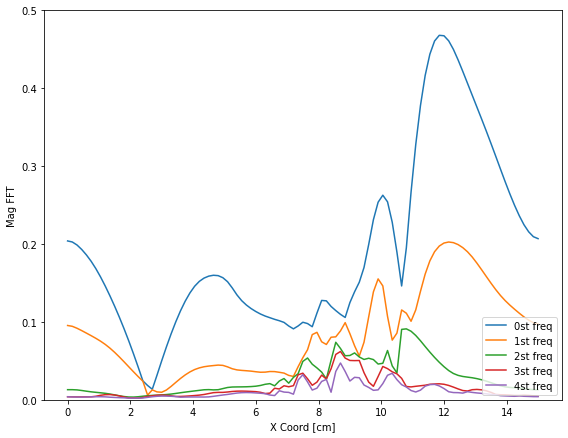

In [15]:
XCoord = np.linspace(0,15,len(LISTSECON[0]))
f,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(5):
    ax.plot(XCoord,LISTSECON[i],label="{:}st freq".format(i))
ax.legend(loc="lower right")
ax.set_ylabel("Mag FFT")
ax.set_ylim(0,0.5)
plt.setp(ax.get_xticklabels(), visible=True)
plt.tight_layout()
ax.set_xlabel("X Coord [cm]")
plt.show()

In [16]:
print(np.argmin(LISTSECON[0]))
print(XCoord[np.argmin(LISTSECON[0])])
print(LISTSECON[0][np.argmin(LISTSECON[0])])

18
2.6999999999999997
0.013550273870057137
